In [ ]:
!pip install PyPortfolioOpt
#Import các thư viện và mount Google Drive:
import pandas as pd
import numpy as np
from scipy.optimize import minimize
from google.colab import drive, files
import matplotlib.pyplot as plt
from pypfopt import black_litterman, risk_models, expected_returns

drive.mount('/content/gdrive', force_remount=True)
path = "gdrive/My Drive/port/"

Mounted at /content/gdrive


In [ ]:
file_path = path + 'port.xlsx'
prices = pd.read_excel(file_path, sheet_name='Prices', index_col='Date', parse_dates=True)
market_caps = pd.read_excel(file_path, sheet_name='MarketCap')
parameters = pd.read_excel(file_path, sheet_name='Parameters')

<ipython-input-3-317ef544ff7f>:2: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  prices = pd.read_excel(file_path, sheet_name='Prices', index_col='Date', parse_dates=True)


In [ ]:
tickers = ['REE', 'HAH', 'ANV', 'PNJ']
filtered_prices = prices[tickers]

# Directly print the result since 'print_result' is not defined
print("Filtered Prices:")
print(filtered_prices.head())

Filtered Prices:
                REE      HAH      ANV      PNJ
Date                                          
2024-07-19  70300.0  43000.0  36000.0  95700.0
2024-07-18  72000.0  43950.0  35500.0  96000.0
2024-07-17  72200.0  42500.0  34550.0  95900.0
2024-07-16  73900.0  44350.0  34800.0  97100.0
2024-07-15  72000.0  45150.0  35500.0  97700.0


In [ ]:
# Đầu tiên, sắp xếp lại dữ liệu từ ngày cũ nhất đến mới nhất
filtered_prices = filtered_prices.sort_index(ascending=True)

# Tính toán lợi suất kỳ vọng (expected returns) và ma trận hiệp phương sai (covariance matrix)
mu = expected_returns.mean_historical_return(filtered_prices)
S = risk_models.sample_cov(filtered_prices)

# In kết quả
print("Expected Returns (mu):")
print(mu)
print("Covariance Matrix (S):")
print(S)

Expected Returns (mu):
REE    0.363207
HAH    0.808784
ANV    0.247567
PNJ    0.235503
dtype: float64
Covariance Matrix (S):
          REE       HAH       ANV       PNJ
REE  0.114086  0.067779  0.080692  0.045136
HAH  0.067779  0.234843  0.125180  0.042404
ANV  0.080692  0.125180  0.256446  0.051600
PNJ  0.045136  0.042404  0.051600  0.091349


In [ ]:
# Xử lý dữ liệu vốn hóa thị trường
# Check if 'Ticker' exists, if not, try to find the correct column
if 'Ticker' not in market_caps.columns:
  # List all columns to help identify the correct one
  print(market_caps.columns)
  # Assuming the ticker column is named 'Mã CK' based on the global variables output
  market_caps.set_index('Mã CK', inplace=True)
else:
  market_caps.set_index('Ticker', inplace=True)

market_caps['MarketCap'] = market_caps['MarketCap'].astype(float)

In [ ]:
# Lấy vốn hóa thị trường của VNINDEX
vnindex_market_cap = market_caps.loc['VNINDEX', 'MarketCap']
print("Market Capitalizations:", vnindex_market_cap) # Use the built-in print function

Market Capitalizations: 6735064000000000.0


In [ ]:
# Tính tỷ trọng thị trường (Market Weights) cho các cổ phiếu trong danh mục
market_weights = market_caps.loc[tickers, 'MarketCap'] / vnindex_market_cap
market_weights = market_weights.to_dict()
print("Tỷ trọng thị trường:\n", market_weights)

Tỷ trọng thị trường:
 {'REE': 0.004905875383158943, 'HAH': 0.0007747146551242869, 'ANV': 0.0007115898812542835, 'PNJ': 0.0047538306569915294}


In [ ]:
risk_free_rate = parameters.loc[parameters['Parameter'] == 'RiskFreeRate', 'Value'].iloc[0]
risk_free_rate = float(str(risk_free_rate).replace(',', '.'))  # Chuyển đổi từ chuỗi có dấu phẩy sang float
print("Risk-Free Rate", risk_free_rate)

Risk-Free Rate 0.02


In [ ]:
views_dict = {'REE': 0.20, 'HAH': 0.28, 'ANV': 0.18, 'PNJ': -0.1}
print("Investor Views", views_dict)
omega = np.diag([0.01, 0.01, 0.01, 0.01])

Investor Views {'REE': 0.2, 'HAH': 0.28, 'ANV': 0.18, 'PNJ': -0.1}


In [ ]:
bl = black_litterman.BlackLittermanModel(S, pi=None, absolute_views=views_dict, omega=omega, market_caps=market_weights)
bl_mu = bl.bl_returns()
bl_S = bl.bl_cov()
print("Black-Litterman Expected Returns (bl_mu)")
print(bl_mu)
print("Black-Litterman Covariance Matrix (bl_S)")
print(bl_S)

Black-Litterman Expected Returns (bl_mu)
REE    0.091554
HAH    0.169507
ANV    0.138291
PNJ    0.008915
dtype: float64
Black-Litterman Covariance Matrix (bl_S)
          REE       HAH       ANV       PNJ
REE  0.117209  0.068507  0.081619  0.045931
HAH  0.068507  0.239738  0.126404  0.042818
ANV  0.081619  0.126404  0.261502  0.052154
PNJ  0.045931  0.042818  0.052154  0.094203


/usr/local/lib/python3.10/dist-packages/pypfopt/black_litterman.py:259: UserWarning: Running Black-Litterman with no prior.
  warnings.warn("Running Black-Litterman with no prior.")


Optimal Weights [0.47036761 0.33419977 0.11267656 0.08275606]


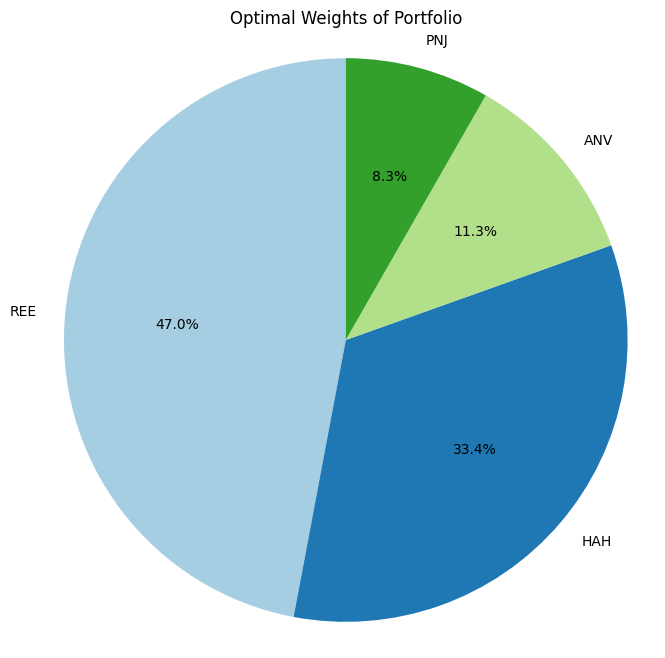

In [ ]:
# Hàm tối ưu hóa danh mục
def portfolio_optimization(mu, cov_matrix):
    num_assets = len(mu)
    args = (mu, cov_matrix)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0, 1) for asset in range(num_assets))

    def portfolio_variance(weights, mu, cov_matrix):
        return np.dot(weights.T, np.dot(cov_matrix, weights)) - np.dot(mu, weights)

    result = minimize(portfolio_variance, num_assets * [1. / num_assets,], args=args,
                      method='SLSQP', bounds=bounds, constraints=constraints)

    return result.x

# Tối ưu hóa danh mục dựa trên lợi nhuận kỳ vọng Black-Litterman
optimal_weights = portfolio_optimization(bl_mu, bl_S)
print("Optimal Weights", optimal_weights)

# Vẽ biểu đồ tròn tỷ trọng tối ưu của các cổ phiếu trong danh mục
fig, ax = plt.subplots(figsize=(8, 8))
ax.pie(optimal_weights, labels=tickers, autopct='%1.1f%%', startangle=90, colors=plt.cm.Paired(np.arange(len(tickers))))

ax.axis('equal')  # Đảm bảo biểu đồ tròn
plt.title('Optimal Weights of Portfolio')
plt.show()

In [ ]:
# Hiển thị kết quả
portfolio_df = pd.DataFrame({
    'Asset': tickers,
    'Market Weight': market_weights.values(),
    'Optimal Weight': optimal_weights,
    'Black-Litterman Return': bl_mu
})
print("Portfolio Optimization Results")
print(portfolio_df)

Portfolio Optimization Results
    Asset  Market Weight  Optimal Weight  Black-Litterman Return
REE   REE       0.004906        0.470368                0.091554
HAH   HAH       0.000775        0.334200                0.169507
ANV   ANV       0.000712        0.112677                0.138291
PNJ   PNJ       0.004754        0.082756                0.008915
